In [1]:
import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
from pathlib import Path

path = str(Path().resolve())
path = path + "\\ADNI_PROCESSED"

def apply_mask(img_n_mmni, img_mask):
    """
        Taking a n_mmni and apply the correspondant mask
        param:
            img_n_mmi   : image n_mmi
            img_mask    : mask
    """
    mmni_m = img_n_mmni.get_fdata()
    mask_m = img_mask.get_fdata().astype(bool)
    mask_bg = np.logical_not(mask_m)
    mmni_m[mask_bg] = 0
    return mmni_m

def process_irm_data():
    """
        Create a new directory and process all images from tha ADNI1 directory
    """
    path = str(Path().resolve())
    path_res = path + "\\ADNI_PROCESSED"
    Path(path_res).mkdir(parents=True, exist_ok=True) # Create a directory for data processed
    path = path + "\\ADNI1"
    for filename in os.listdir(path):
        if filename.startswith("n_mmni"):
            n_mmni_filename = os.path.join(path, filename)
            mask_filename = os.path.join(path, "mask_" + filename)
            img_n_mmni = nib.load(n_mmni_filename)
            img_mask = nib.load(mask_filename)
            n_mmni_mask = apply_mask(img_n_mmni, img_mask)
            img = nib.Nifti1Image(n_mmni_mask, np.eye(4))
            nib.save(img, os.path.join(path_res, filename))

# process_irm_data()

In [2]:
def load_processed_data(path):
    """
        load all n_mmni found in the path
    """
    if not os.path.isdir(path):
        print("Can't found directory: " + path)
    else:
        list_x = []
        for filename in os.listdir(path):
            n_mmni_filename = os.path.join(path, filename)
            img_n_mmni = nib.load(n_mmni_filename)
            mmni_matrix = img_n_mmni.get_fdata()
            list_x.append((filename, mmni_matrix))
        return list_x

In [3]:
def cut_2D_i(img_n_mmni, axe, idx):
    """
        Function that returns a 2D cut from the "img" in the index "idx", along the axe given in parameter
    """
    axe_dim = {"x": img_n_mmni.shape[0], "y": img_n_mmni.shape[1], "z":img_n_mmni.shape[2]}
    if axe_dim[axe] <= idx or idx < 0:
        print("Invalid value for index must be between 0 and " , axe_dim[axe])
        return
    if axe == "x":
        cropped_img = img_n_mmni.slicer[idx:idx+1, 18:199, :]
        img_data = cropped_img.get_fdata()
        img_data = np.transpose(img_data, (2, 1, 0)) / 255.0
        img_data = np.transpose(img_data, (1, 0, 2)) / 255.0
    elif axe == "y":
        cropped_img = img_n_mmni.slicer[45:145, idx:idx+1,35:135] #eliminate black borders
        img_data = cropped_img.get_fdata()
        img_data = np.transpose(img_data, (0, 2, 1)) / 255.0
    elif axe == "z":
        cropped_img = img_n_mmni.slicer[:, 18:199, idx:idx+1]
        img_data = cropped_img.get_fdata()
    else:
        print("Choose a valid value for axe: x, y or z")

    return img_data

def custom_patch_3D(img_n_mmni, x_tup, y_tup, z_tup):
    axe_dim = {"x": img_n_mmni.shape[0], "y": img_n_mmni.shape[1], "z":img_n_mmni.shape[2]}
    if axe_dim["x"] <= x_tup[1] or x_tup[0] < 0 or axe_dim["y"] <= y_tup[1] or y_tup[0] < 0 or axe_dim["z"] <= z_tup[1] or z_tup[0] < 0 :
        print("Invalid values")
        return 
    else:
        cropped_img = img_n_mmni.slicer[x_tup[0]:x_tup[1], y_tup[0]:y_tup[1], z_tup[0]:z_tup[1]]
        img_data = cropped_img.get_fdata()
        img_data.resize(img_data.shape + (1, ))
        return img_data

# To test thid function
n_mmni_filename = os.path.join(path, "n_mmni_fADNI_002_S_0295_1.5T_t1w.nii.gz")
img_n_mmni = nib.load(n_mmni_filename)
data_img = cut_2D_i(img_n_mmni, "x", 95)
print(data_img.shape)
crop_img = nib.Nifti1Image(data_img, np.eye(4))
nib.save(crop_img, 'test_img.nii')

(181, 181, 1)


In [4]:
## NOT USED
def load_X_data(path):
    if not os.path.isdir(path):
        print("Can't found directory: " + path)
    else:
        list_x = []
        for filename in os.listdir(path):
            n_mmni_filename = os.path.join(path, filename)
            img_n_mmni = nib.load(n_mmni_filename)
            # Customize your choice: taking a 2D cuts or 3D patches
            cropped_img = cut_2D_i(img_n_mmni, "y", 106)
            cropped_n_mmni_matrix = cropped_img.get_fdata()
            list_x.append((filename, cropped_n_mmni_matrix))
        return list_x

# X_data = load_X_data(path)

In [4]:
import os
import re
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

def load_data(path):
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group'])
    data.index = data['Subject ID']
    data = data.drop(['Subject ID'], axis=1)
    data = data[(data.Group == 'CN') | (data.Group == 'AD')]
    return data

path = str(Path().resolve())
path = path + "/ADNI1/list_standardized_tongtong_2017.csv"
y_data = load_data(path)
y_data.head(7)

,Rooster ID,Group
Subject ID,,
002_S_0295,295,CN
002_S_0413,413,CN
002_S_0559,559,CN
002_S_0619,619,AD
002_S_0685,685,CN
002_S_0816,816,AD
002_S_0938,938,AD


In [5]:
from tensorflow.keras.utils import to_categorical

usecols = ['Subject ID', 'Rooster ID', 'Group']
# ['CN', 'AD']
def prepare_X_of_Y(Y):
    X_data = []
    Y_data = []
    X_test_index = []
    Y_test = []
    path = str(Path().resolve())
    path += "\\ADNI_PROCESSED"
    n_test_AD = 0
    n_test_CN = 0
    for index, row in Y.iterrows():
        file = path + '\\n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        if os.path.isfile(file):
            img_n_mmni = nib.load(file)
            # Taking 4 images for test purpose
            if (Y['Group'][index] == 'AD' and n_test_AD < 2) or (Y['Group'][index] == 'CN' and n_test_CN < 2):
                n_test_AD += 1 if Y['Group'][index] == 'AD' else n_test_AD
                n_test_CN += 1 if Y['Group'][index] == 'CN' else n_test_CN
                X_test_index.append(index)
            else:
                for i in range(100, 112):
                    img_data = cut_2D_i(img_n_mmni, 'y', i)
                    X_data.append(img_data)
                    if Y['Group'][index] == 'AD':
                        Y_data.append(1)
                    elif Y['Group'][index] == 'CN':
                        Y_data.append(0)
        else:
            Y.drop(index, inplace=True)
    return np.array(X_data), Y_data, X_test_index

if os.path.isfile('X_data.npy') and os.path.isfile('Y_data.npy') and os.path.isfile('X_test_index.npy'):
    X_data = np.load('X_data.npy')
    Y_data = np.load('Y_data.npy')
    X_test_index = np.load('X_test_index.npy')
else:
    X_data, Y_data_list, X_test_index = prepare_X_of_Y(y_data)
    Y_data = to_categorical(Y_data_list, num_classes=2)
    np.save('X_data', X_data)
    np.save('Y_data', Y_data)
    np.save('X_test_index', X_test_index)
    
print(len(X_data) == len(Y_data))

True


In [5]:
from tensorflow.keras.utils import to_categorical

usecols = ['Subject ID', 'Rooster ID', 'Group']
# ['CN', 'AD']
def prepare_X_of_Y_3D(Y):
    X_data = []
    Y_data = []
    X_test_index = []
    Y_test = []
    path = str(Path().resolve())
    path += "\\ADNI_PROCESSED"
    n_test_AD = 0
    n_test_CN = 0
    for index, row in Y.iterrows():
        file = path + '\\n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        if os.path.isfile(file):
            img_n_mmni = nib.load(file)
            # Taking 4 images for test purpose
            if (Y['Group'][index] == 'AD' and n_test_AD < 2) or (Y['Group'][index] == 'CN' and n_test_CN < 2):
                n_test_AD += 1 if Y['Group'][index] == 'AD' else n_test_AD
                n_test_CN += 1 if Y['Group'][index] == 'CN' else n_test_CN
                X_test_index.append(index)
            else:
                img_data = custom_patch_3D(img_n_mmni, x_tup=(40, 140), y_tup=(90, 110), z_tup=(35, 135))
                X_data.append(img_data)
                if Y['Group'][index] == 'AD':
                    Y_data.append(1)
                elif Y['Group'][index] == 'CN':
                    Y_data.append(0)
        else:
            Y.drop(index, inplace=True)
    return np.array(X_data), Y_data, X_test_index

if os.path.isfile('X_data_3D.npy') and os.path.isfile('Y_data_3D.npy') and os.path.isfile('X_test_index_3D.npy'):
    X_data_3D = np.load('X_data_3D.npy')
    Y_data_3D = np.load('Y_data_3D.npy')
    X_test_index_3D = np.load('X_test_index_3D.npy')
else:
    X_data_3D, Y_data_list_3D, X_test_index_3D = prepare_X_of_Y_3D(y_data)
    Y_data_3D = to_categorical(Y_data_list_3D, num_classes=2)
    np.save('X_data_3D', X_data_3D)
    np.save('Y_data_3D', Y_data_3D)
    np.save('X_test_index_3D', X_test_index_3D)
    
print(len(X_data_3D) == len(Y_data_3D))

True


{0: 'CN', 1: 'AD'}


c:\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


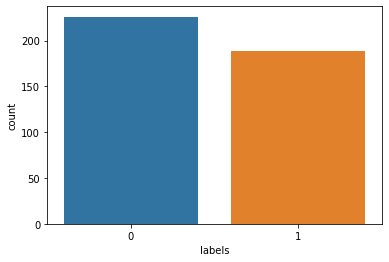

In [6]:
map_characters = {0: 'CN', 1: 'AD'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"] = Y_data_list_3D
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

## Loss visualization function
This function is used to visualize the variations of loss, val_loss, accuracy and val_accuracy over epochs. It is used for 3D and 2D models. 

In [ ]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
      """
      Returns separate loss curves for training and validation metrics.
      """ 
      loss = history.history['loss']
      val_loss = history.history['val_loss']

      accuracy = history.history['accuracy']
      val_accuracy = history.history['val_accuracy']

      epochs = range(len(history.history['loss']))

      # Plot loss
      plt.plot(epochs, loss, label='training_loss')
      plt.plot(epochs, val_loss, label='val_loss')
      plt.title('Loss')
      plt.xlabel('Epochs')
      plt.legend()

      # Plot accuracy
      plt.figure()
      plt.plot(epochs, accuracy, label='training_accuracy')
      plt.plot(epochs, val_accuracy, label='val_accuracy')
      plt.title('Accuracy')
      plt.xlabel('Epochs')
      plt.legend()

# U-Net Neural Network

Creation of two U-Net models:
* One for 2D inputs, in case we slice the input into 2D images.
* The other for 3D inputs, in case we use 3D blocs of the image.

### 2D implementation of classification model
- Creation of an auto-encoder model and an only encoder model.
- compilation of the model using adam optimizer, and binary_crossentropy loss.
- fiting the model using GPU if it exists.

In [7]:
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, UpSampling2D, Cropping2D, Conv3D, MaxPooling3D, UpSampling3D, Cropping3D, Input, concatenate, Flatten, Dense, Dropout, BatchNormalization, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalAveragePooling3D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def create_Unet_model2D(input_size, depth=5, padding='valid'):
    inputs = Input(shape=input_size)
    x = inputs
    num_filters = 64
    encode_layers_list = []
    for i in range(depth):
        x = Conv2D(filters=num_filters, kernel_size=(3,3), padding=padding, activation='relu')(x)
        x = Conv2D(filters=num_filters, kernel_size=(3,3), padding=padding, activation='relu')(x)
        if i != depth - 1:
            encode_layers_list.append(x)
            x = MaxPooling2D(pool_size=(2,2), strides=2)(x)
            num_filters *= 2
    
    for i in range(depth - 1):
        x = UpSampling2D()(x)
        x = Conv2D(filters=num_filters, kernel_size=(2,2), padding='same', activation='relu')(x)
        #cropping
        encoder_shape = encode_layers_list[depth - 2 - i].shape
        decoder_shape = x.shape
        shape_diff = (encoder_shape[1] - decoder_shape[1], encoder_shape[2] - decoder_shape[2])
        xshape_diff = shape_diff[0] // 2
        yshape_diff = shape_diff[1] // 2
        if shape_diff[0] % 2 != 0:
            xshape_diff = (shape_diff[0] // 2, shape_diff[0] // 2 + 1)
        if shape_diff[1] % 2 != 0:
            yshape_diff = (shape_diff[1] // 2, shape_diff[1] // 2 + 1)
        croped_layer = Cropping2D(cropping=(xshape_diff, yshape_diff))(encode_layers_list[depth - 2 - i])
        
        x = concatenate([croped_layer, x])
        num_filters /= 2
        x = Conv2D(filters=num_filters, kernel_size=(3,3), padding=padding, activation='relu')(x)
        x = Conv2D(filters=num_filters, kernel_size=(3,3), padding=padding, activation='relu')(x)

    outputs = Conv2D(filters=2, padding=padding, kernel_size=(1,1))(x)
        
    return Model(inputs, outputs)

def create_Unet_model2D_encoder(input_size, depth=5, padding='valid', nb_class=2):
    inputs = Input(shape=input_size)
    x = inputs
    num_filters = 64
    for i in range(depth):
        x = SeparableConv2D(filters=num_filters, kernel_size=(3,3), padding=padding)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        x = SeparableConv2D(filters=num_filters, kernel_size=(3,3), padding=padding)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        if i != depth - 1:
            x = MaxPooling2D(pool_size=(2,2), strides=2)(x)
            num_filters *= 2

    # Flattenting
    x = GlobalAveragePooling2D()(x)
    
    x = Dropout(0.5)(x)
    outputs = Dense(nb_class, activation='sigmoid')(x)

    return Model(inputs, outputs)

In [ ]:
from tensorflow.keras.optimizers import Adam

model_2 = create_Unet_model2D_encoder(X_data[0].shape, depth=4)
# model_2.compile(optimizer='adam', loss='squared_hinge', metrics=['accuracy'])
model_2.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model_2.summary()

In [ ]:
import tensorflow as tf
y = np.array([y[1] for y in Y_data])
x = np.array([tf.image.grayscale_to_rgb(tf.convert_to_tensor(img), name=None) for img in X_data])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=0.25,random_state=42)
print("Data splited")

In [ ]:
import matplotlib.pyplot as plt
def show_batch(image_batch, label_X):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_X[n]:
            plt.title("AD")
        else:
            plt.title("CN")
        plt.axis("off")
show_batch(X_val, Y_val)

In [8]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices()
print(physical_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
history = model_2.fit(X_train, Y_train, epochs= 50, validation_data=(X_val, Y_val))

In [ ]:
plot_loss_curves(history)

In [ ]:
model_2.save('model_2D')

### 3D implementation of classification model
- Creation of an auto-encoder model and an only encoder model.
- compilation of the model using adam optimizer, and binary_crossentropy loss.
- fiting the model using GPU if it exists.

In [ ]:
def create_Unet_model3D(input_size, depth=5, padding='valid'):
    inputs = Input(shape=input_size)
    x = inputs
    num_filters = 64
    encode_layers_list = []
    for i in range(depth):
        x = Conv3D(filters=num_filters, kernel_size=(3,3,3), padding=padding, activation='relu')(x)
        x = Conv3D(filters=num_filters, kernel_size=(3,3,3), padding=padding, activation='relu')(x)
        if i != depth - 1:
            encode_layers_list.append(x)
            x = MaxPooling3D(pool_size=(2,2,2), strides=2)(x)
            num_filters *= 2
    

    for i in range(depth - 1):
        x = UpSampling3D()(x)
        x = Conv3D(filters=num_filters, kernel_size=(2,2,2), activation='relu', padding='same')(x)
        #cropping
        encoder_shape = encode_layers_list[depth - 2 - i].shape
        decoder_shape = x.shape
        shape_diff = (encoder_shape[1] - decoder_shape[1], encoder_shape[2] - decoder_shape[2], encoder_shape[3] - decoder_shape[3])
        xshape_diff = shape_diff[0] // 2
        yshape_diff = shape_diff[1] // 2
        zshape_diff = shape_diff[2] // 2
        if shape_diff[0] % 2 != 0:
            xshape_diff = (shape_diff[0] // 2, shape_diff[0] // 2 + 1)
        if shape_diff[1] % 2 != 0:
            yshape_diff = (shape_diff[1] // 2, shape_diff[1] // 2 + 1)
        if shape_diff[2] % 2 != 0:
            zshape_diff = (shape_diff[2] // 2, shape_diff[2] // 2 + 1)
        croped_layer = Cropping3D(cropping=(xshape_diff, yshape_diff, zshape_diff))(encode_layers_list[depth - 2 - i])

        x = concatenate([croped_layer, x])
        num_filters /= 2
        x = Conv3D(filters=num_filters, kernel_size=(3,3,3), padding=padding, activation='relu')(x)
        x = Conv3D(filters=num_filters, kernel_size=(3,3,3), padding=padding, activation='relu')(x)

    outputs = Conv3D(filters=2, kernel_size=(1,1,1))(x)
        
    return Model(inputs, outputs)

def create_Unet_model3D_encoder(input_size, depth=5, padding='valid', nb_class=2):
    inputs = Input(shape=input_size)
    x = inputs
    num_filters = 64
    for i in range(depth):
        x = Conv3D(filters=num_filters, kernel_size=(3,3,3), padding=padding)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv3D(filters=num_filters, kernel_size=(3,3,3), padding=padding)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        if i != depth - 1:
            x = MaxPooling3D(pool_size=(2,2,2), strides=2)(x)
            num_filters *= 2
    
    x = GlobalAveragePooling3D()(x)

    x = Dropout(0.5)(x)
    outputs = Dense(nb_class, activation='sigmoid')(x)

    return Model(inputs, outputs)

In [10]:
model_3 = create_Unet_model3D_encoder(X_data_3D[0].shape, depth=2)
# model_2.compile(optimizer='adam', loss='squared_hinge', metrics=['accuracy'])
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 20, 100, 1)  0         
                             ]                                   
                                                                 
 conv3d_5 (Conv3D)           (None, 98, 18, 98, 64)    1792      
                                                                 
 batch_normalization_4 (Batc  (None, 98, 18, 98, 64)   256       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 98, 18, 98, 64)    0         
                                                                 
 conv3d_6 (Conv3D)           (None, 96, 16, 96, 64)    110656    
                                                                 
 batch_normalization_5 (Batc  (None, 96, 16, 96, 64)   256   

In [11]:
from sklearn.model_selection import train_test_split

X_train_3D, X_val_3D, Y_train_3D, Y_val_3D = train_test_split(X_data_3D, Y_data_3D, test_size=0.25,random_state=42)
print("Data splited")

Data splited


In [16]:
history = model_3.fit(X_train_3D, Y_train_3D, epochs= 50, batch_size=8, validation_data=(X_val_3D, Y_val_3D))

Epoch 1/50
39/39 [==============================] - 24s 525ms/step - loss: 0.6155 - accuracy: 0.6881 - val_loss: 0.8791 - val_accuracy: 0.5769
Epoch 2/50
39/39 [==============================] - 18s 455ms/step - loss: 0.5965 - accuracy: 0.6785 - val_loss: 15.2468 - val_accuracy: 0.4615
Epoch 3/50
39/39 [==============================] - 18s 456ms/step - loss: 0.5777 - accuracy: 0.6817 - val_loss: 2.2577 - val_accuracy: 0.4615
Epoch 4/50
39/39 [==============================] - 18s 458ms/step - loss: 0.5606 - accuracy: 0.7395 - val_loss: 1.0967 - val_accuracy: 0.5385
Epoch 5/50
39/39 [==============================] - 18s 459ms/step - loss: 0.5478 - accuracy: 0.7395 - val_loss: 6.3585 - val_accuracy: 0.5385
Epoch 6/50
39/39 [==============================] - 18s 460ms/step - loss: 0.5250 - accuracy: 0.7524 - val_loss: 9.1129 - val_accuracy: 0.5385
Epoch 7/50
39/39 [==============================] - 18s 460ms/step - loss: 0.5288 - accuracy: 0.7588 - val_loss: 2.8265 - val_accuracy: 0.538

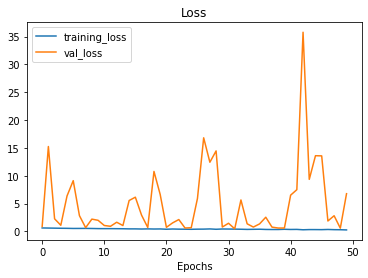

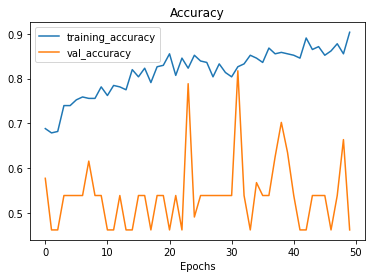

In [17]:
plot_loss_curves(history)

In [ ]:
final_test_X = []
path = str(Path().resolve())
path = path + "\\ADNI_PROCESSED"
for index in X_test_index:
    file = path + '\\n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
    if os.path.isfile(file):
        img_n_mmni = nib.load(file)
        img_data = cut_2D_i(img_n_mmni, "y", 102)
        #img_data = np.transpose(img_data, (0, 2, 1))/255.0
        final_test_X.append(img_data)
final_test_X = np.array(final_test_X)
y_pred = model_2.predict(final_test_X)
print(y_pred)
plt.figure(figsize=(10,10))
for n in range(len(X_test_index)):
    ax = plt.subplot(2,2,n+1)
    plt.imshow(final_test_X[n])
    title = "Probability of: " + str(y_pred[n][0]*100) + "% AD"
    plt.title(title)

for n in range(len(X_test_index)):
    print("IRM Correspond to : " + y_data['Group'][X_test_index[n]] + ", Prediction: " + str(y_pred[n][0]*100) + "% AD")